In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples=100

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for SBL results
z_sbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # SBL results
gamma_sbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # SBL gamma values
hit_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for SBL
support_recovery_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for SBL
false_alarm_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for SBL
norm_mse_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for SBL

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_sbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for SBL
        hit_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for sbl
        support_recovery_rate_sbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for SBL
        false_alarm_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for SBL
        norm_mse_sbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.72s/it]

Converged after 426 iterations



Processing Samples:   1%|          | 1/100 [01:27<2:23:54, 87.22s/it]

Converged after 344 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.16s/it]

Converged after 394 iterations



Processing Samples:   2%|▏         | 2/100 [02:54<2:22:26, 87.20s/it]

Converged after 462 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.47s/it]

Converged after 437 iterations



Processing Samples:   3%|▎         | 3/100 [04:19<2:19:07, 86.06s/it]

Converged after 386 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.41s/it]

Converged after 432 iterations



Processing Samples:   6%|▌         | 6/100 [08:47<2:19:07, 88.80s/it]

Converged after 357 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.62s/it]

Converged after 448 iterations



Processing Samples:   7%|▋         | 7/100 [10:13<2:16:21, 87.97s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.61s/it]

Converged after 445 iterations



Processing Samples:   8%|▊         | 8/100 [11:41<2:14:47, 87.91s/it]

Converged after 456 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.90s/it]

Converged after 483 iterations



Processing Samples:   9%|▉         | 9/100 [13:03<2:10:41, 86.17s/it]

Converged after 292 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.12s/it]

Converged after 419 iterations



Processing Samples:  10%|█         | 10/100 [14:28<2:08:32, 85.70s/it]

Converged after 400 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.70s/it]

Converged after 462 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.90s/it]

Converged after 452 iterations



Processing Samples:  12%|█▏        | 12/100 [17:23<2:06:38, 86.34s/it]

Converged after 370 iterations



Processing Samples:  13%|█▎        | 13/100 [19:00<2:10:02, 89.69s/it]

Converged after 498 iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:43<00:43, 14.46s/it]

Converged after 499 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.06s/it]

Converged after 429 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.06s/it]

Converged after 350 iterations



Processing Samples:  14%|█▍        | 14/100 [20:21<2:04:40, 86.98s/it]

Converged after 410 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.10s/it]

Converged after 325 iterations



Processing Samples:  15%|█▌        | 15/100 [21:39<1:59:29, 84.35s/it]

Converged after 266 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.90s/it]

Converged after 482 iterations



Processing Samples:  16%|█▌        | 16/100 [23:06<1:59:03, 85.05s/it]

Converged after 411 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.03s/it]

Converged after 416 iterations



Processing Samples:  17%|█▋        | 17/100 [24:33<1:58:37, 85.76s/it]

Converged after 465 iterations



Processing Samples:  18%|█▊        | 18/100 [26:01<1:57:44, 86.15s/it]

Converged after 390 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.22s/it]

Converged after 409 iterations



Processing Samples:  19%|█▉        | 19/100 [27:24<1:55:20, 85.43s/it]

Converged after 369 iterations



Processing Samples:  21%|██        | 21/100 [30:26<1:55:46, 87.93s/it]

Converged after 377 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:29, 14.60s/it]

Converged after 476 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.63s/it]

Converged after 464 iterations



Processing Samples:  23%|██▎       | 23/100 [33:23<1:52:38, 87.77s/it]

Converged after 385 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.39s/it]

Converged after 464 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.41s/it]

Converged after 476 iterations



Processing Samples:  24%|██▍       | 24/100 [34:48<1:50:18, 87.08s/it]

Converged after 399 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.79s/it]

Converged after 468 iterations



Processing Samples:  25%|██▌       | 25/100 [36:15<1:48:52, 87.11s/it]

Converged after 418 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.33s/it]

Converged after 432 iterations



Processing Samples:  26%|██▌       | 26/100 [37:40<1:46:30, 86.36s/it]

Converged after 380 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:29, 14.59s/it]

Converged after 472 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.72s/it]

Converged after 476 iterations



Processing Samples:  27%|██▋       | 27/100 [39:02<1:43:22, 84.97s/it]

Converged after 316 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.54s/it]

Converged after 333 iterations



Processing Samples:  28%|██▊       | 28/100 [40:26<1:41:42, 84.76s/it]

Converged after 436 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.40s/it]

Converged after 420 iterations



Processing Samples:  29%|██▉       | 29/100 [41:50<1:39:58, 84.49s/it]

Converged after 333 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.44s/it]

Converged after 439 iterations



Processing Samples:  30%|███       | 30/100 [43:15<1:38:54, 84.78s/it]

Converged after 418 iterations



Processing Samples:  31%|███       | 31/100 [44:42<1:38:03, 85.27s/it]

Converged after 372 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.90s/it]

Converged after 388 iterations



Processing Samples:  32%|███▏      | 32/100 [46:05<1:36:09, 84.85s/it]

Converged after 411 iterations



Processing Samples:  33%|███▎      | 33/100 [47:33<1:35:38, 85.65s/it]

Converged after 385 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.79s/it]

Converged after 466 iterations



Processing Samples:  34%|███▍      | 34/100 [48:57<1:33:41, 85.17s/it]

Converged after 368 iterations



Processing Samples:  35%|███▌      | 35/100 [50:22<1:32:19, 85.22s/it]

Converged after 385 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.22s/it]

Converged after 452 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.17s/it]

Converged after 341 iterations



Processing Samples:  36%|███▌      | 36/100 [51:45<1:30:14, 84.60s/it]

Converged after 451 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.65s/it]

Converged after 450 iterations



Processing Samples:  37%|███▋      | 37/100 [53:11<1:29:02, 84.80s/it]

Converged after 359 iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:42<00:42, 14.31s/it]

Converged after 484 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.35s/it]

Converged after 464 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.60s/it]

Converged after 472 iterations



Processing Samples:  38%|███▊      | 38/100 [54:37<1:27:58, 85.13s/it]

Converged after 402 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:15, 15.04s/it]

Converged after 469 iterations



Processing Samples:  39%|███▉      | 39/100 [56:06<1:27:47, 86.35s/it]

Converged after 464 iterations



Processing Samples:  41%|████      | 41/100 [59:04<1:26:19, 87.79s/it]

Converged after 453 iterations



Processing Samples:  42%|████▏     | 42/100 [1:00:33<1:25:14, 88.18s/it]

Converged after 452 iterations



Processing Samples:  43%|████▎     | 43/100 [1:01:59<1:23:07, 87.51s/it]

Converged after 339 iterations



Processing Samples:  44%|████▍     | 44/100 [1:03:28<1:22:06, 87.97s/it]

Converged after 421 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:29, 14.61s/it]

Converged after 485 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.66s/it]

Converged after 362 iterations



Processing Samples:  45%|████▌     | 45/100 [1:04:49<1:18:31, 85.66s/it]

Converged after 300 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.82s/it]

Converged after 458 iterations



Processing Samples:  46%|████▌     | 46/100 [1:06:10<1:16:03, 84.50s/it]

Converged after 311 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.20s/it]

Converged after 376 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.67s/it]

Converged after 462 iterations



Processing Samples:  47%|████▋     | 47/100 [1:07:32<1:13:50, 83.59s/it]

Converged after 388 iterations



Processing Samples:  48%|████▊     | 48/100 [1:08:59<1:13:24, 84.70s/it]

Converged after 384 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.35s/it]

Converged after 429 iterations



Processing Samples:  49%|████▉     | 49/100 [1:10:23<1:11:54, 84.60s/it]

Converged after 372 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.21s/it]

Converged after 428 iterations



Processing Samples:  50%|█████     | 50/100 [1:11:46<1:09:58, 83.96s/it]

Converged after 390 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:26, 13.47s/it]

Converged after 369 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.39s/it]

Converged after 412 iterations



Processing Samples:  51%|█████     | 51/100 [1:13:04<1:07:11, 82.27s/it]

Converged after 272 iterations



Processing Samples:  52%|█████▏    | 52/100 [1:14:31<1:07:00, 83.75s/it]

Converged after 393 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:15, 15.03s/it]

Converged after 497 iterations



Processing Samples:  53%|█████▎    | 53/100 [1:16:00<1:06:50, 85.32s/it]

Converged after 465 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.30s/it]

Converged after 414 iterations



Processing Samples:  54%|█████▍    | 54/100 [1:17:23<1:04:52, 84.63s/it]

Converged after 337 iterations



Processing Samples:  55%|█████▌    | 55/100 [1:18:50<1:03:56, 85.25s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.16s/it]

Converged after 424 iterations



Processing Samples:  56%|█████▌    | 56/100 [1:20:14<1:02:15, 84.90s/it]

Converged after 398 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.14s/it]

Converged after 437 iterations



Processing Samples:  57%|█████▋    | 57/100 [1:21:39<1:00:44, 84.75s/it]

Converged after 350 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.83s/it]

Converged after 413 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.45s/it]

Converged after 399 iterations



Processing Samples:  58%|█████▊    | 58/100 [1:22:59<58:27, 83.51s/it]  

Converged after 354 iterations



Processing Samples:  59%|█████▉    | 59/100 [1:24:26<57:43, 84.46s/it]

Converged after 369 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.16s/it]

Converged after 408 iterations



Processing Samples:  60%|██████    | 60/100 [1:25:47<55:38, 83.45s/it]

Converged after 349 iterations



Processing Samples:  61%|██████    | 61/100 [1:27:14<54:55, 84.49s/it]

Converged after 368 iterations



Processing Samples:  62%|██████▏   | 62/100 [1:28:41<54:02, 85.33s/it]

Converged after 449 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.90s/it]

Converged after 380 iterations



Processing Samples:  63%|██████▎   | 63/100 [1:30:05<52:14, 84.72s/it]

Converged after 372 iterations



Processing Samples:  64%|██████▍   | 64/100 [1:31:32<51:22, 85.64s/it]

Converged after 410 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.59s/it]

Converged after 445 iterations



Processing Samples:  65%|██████▌   | 65/100 [1:32:58<50:00, 85.72s/it]

Converged after 405 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.48s/it]

Converged after 466 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.60s/it]

Converged after 465 iterations



Processing Samples:  66%|██████▌   | 66/100 [1:34:21<48:07, 84.93s/it]

Converged after 315 iterations



Processing Samples:  67%|██████▋   | 67/100 [1:35:46<46:43, 84.95s/it]

Converged after 356 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.47s/it]

Converged after 500 iterations



Processing Samples:  68%|██████▊   | 68/100 [1:37:11<45:12, 84.76s/it]

Converged after 348 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.80s/it]

Converged after 467 iterations



Processing Samples:  69%|██████▉   | 69/100 [1:38:37<44:04, 85.32s/it]

Converged after 393 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:15, 15.03s/it]

Converged after 485 iterations



Processing Samples:  70%|███████   | 70/100 [1:40:03<42:41, 85.38s/it]

Converged after 343 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.35s/it]

Converged after 422 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.48s/it]

Converged after 445 iterations



Processing Samples:  72%|███████▏  | 72/100 [1:42:56<40:06, 85.94s/it]

Converged after 392 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.50s/it]

Converged after 474 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.65s/it]

Converged after 482 iterations



Processing Samples:  73%|███████▎  | 73/100 [1:44:22<38:40, 85.96s/it]

Converged after 412 iterations



Processing Samples:  74%|███████▍  | 74/100 [1:45:49<37:20, 86.17s/it]

Converged after 379 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.11s/it]

Converged after 403 iterations



Processing Samples:  75%|███████▌  | 75/100 [1:47:08<34:59, 83.99s/it]

Converged after 277 iterations



Processing Samples:  77%|███████▋  | 77/100 [1:50:05<32:57, 85.97s/it]

Converged after 344 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.91s/it]

Converged after 428 iterations



Processing Samples:  78%|███████▊  | 78/100 [1:51:29<31:19, 85.42s/it]

Converged after 369 iterations



Processing Samples:  79%|███████▉  | 79/100 [1:52:59<30:18, 86.59s/it]

Converged after 466 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:26, 13.37s/it]

Converged after 360 iterations



Processing Samples:  80%|████████  | 80/100 [1:54:22<28:32, 85.62s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.29s/it]

Converged after 451 iterations



Processing Samples:  81%|████████  | 81/100 [1:55:47<27:03, 85.44s/it]

Converged after 370 iterations



Processing Samples:  82%|████████▏ | 82/100 [1:57:16<25:56, 86.48s/it]

Converged after 469 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.64s/it]

Converged after 386 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.05s/it]

Converged after 362 iterations



Processing Samples:  83%|████████▎ | 83/100 [1:58:38<24:06, 85.10s/it]

Converged after 438 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.16s/it]

Converged after 404 iterations



Processing Samples:  84%|████████▍ | 84/100 [1:59:57<22:14, 83.42s/it]

Converged after 295 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.53s/it]

Converged after 451 iterations



Processing Samples:  85%|████████▌ | 85/100 [2:01:22<20:55, 83.71s/it]

Converged after 362 iterations



Processing Samples:  86%|████████▌ | 86/100 [2:02:48<19:43, 84.50s/it]

Converged after 363 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.75s/it]

Converged after 499 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.13s/it]

Converged after 405 iterations



Processing Samples:  87%|████████▋ | 87/100 [2:04:14<18:23, 84.86s/it]

Converged after 434 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.29s/it]

Converged after 415 iterations



Processing Samples:  88%|████████▊ | 88/100 [2:05:41<17:08, 85.73s/it]

Converged after 491 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.94s/it]

Converged after 383 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.73s/it]

Converged after 432 iterations



Processing Samples:  90%|█████████ | 90/100 [2:08:37<14:28, 86.81s/it]

Converged after 465 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:15<00:15, 15.13s/it]

Converged after 459 iterations



Processing Samples:  91%|█████████ | 91/100 [2:10:03<12:58, 86.55s/it]

Converged after 278 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.66s/it]

Converged after 381 iterations



Processing Samples:  93%|█████████▎| 93/100 [2:12:55<10:05, 86.46s/it]

Converged after 348 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:58<00:30, 15.08s/it]

Converged after 494 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.48s/it]

Converged after 405 iterations



Processing Samples:  94%|█████████▍| 94/100 [2:14:18<08:30, 85.14s/it]

Converged after 386 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.65s/it]

Converged after 340 iterations



Processing Samples:  95%|█████████▌| 95/100 [2:15:40<07:01, 84.23s/it]

Converged after 331 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.12s/it]

Converged after 435 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.14s/it]

Converged after 378 iterations



Processing Samples:  96%|█████████▌| 96/100 [2:17:03<05:35, 83.86s/it]

Converged after 448 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:55<00:27, 14.00s/it]

Converged after 451 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.48s/it]

Converged after 473 iterations



Processing Samples:  97%|█████████▋| 97/100 [2:18:27<04:11, 83.89s/it]

Converged after 394 iterations



Processing Samples:  98%|█████████▊| 98/100 [2:19:59<02:52, 86.35s/it]

Converged after 484 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:13<00:15, 15.14s/it]

Converged after 497 iterations



Processing Samples:  99%|█████████▉| 99/100 [2:21:25<01:26, 86.33s/it]

Converged after 373 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.11s/it]

Converged after 395 iterations



Processing Samples: 100%|██████████| 100/100 [2:22:48<00:00, 85.68s/it]

Converged after 392 iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_sbl = np.mean(support_recovery_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [33.2 76.8 98.4 99.8 99.9 99.8]
Average Support Recovery Rate across samples per SNR level: [0.13587791 0.44517841 0.84520679 0.93310689 0.96833333 0.98833333]
Average False Alarm Rate across samples per SNR level: [2.48717949 1.65897436 0.43076923 0.18974359 0.08717949 0.02307692]
Average Normalized MSE across samples per SNR level: [0.79078446 0.37534582 0.08351925 0.04699469 0.0339882  0.02672576]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/e1-results-100-sbl-pilot-length-all-snr-db-12.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    support_recovery_rate_sbl=support_recovery_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_support_recovery_rate_sbl=avg_support_recovery_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved")

All results have been saved


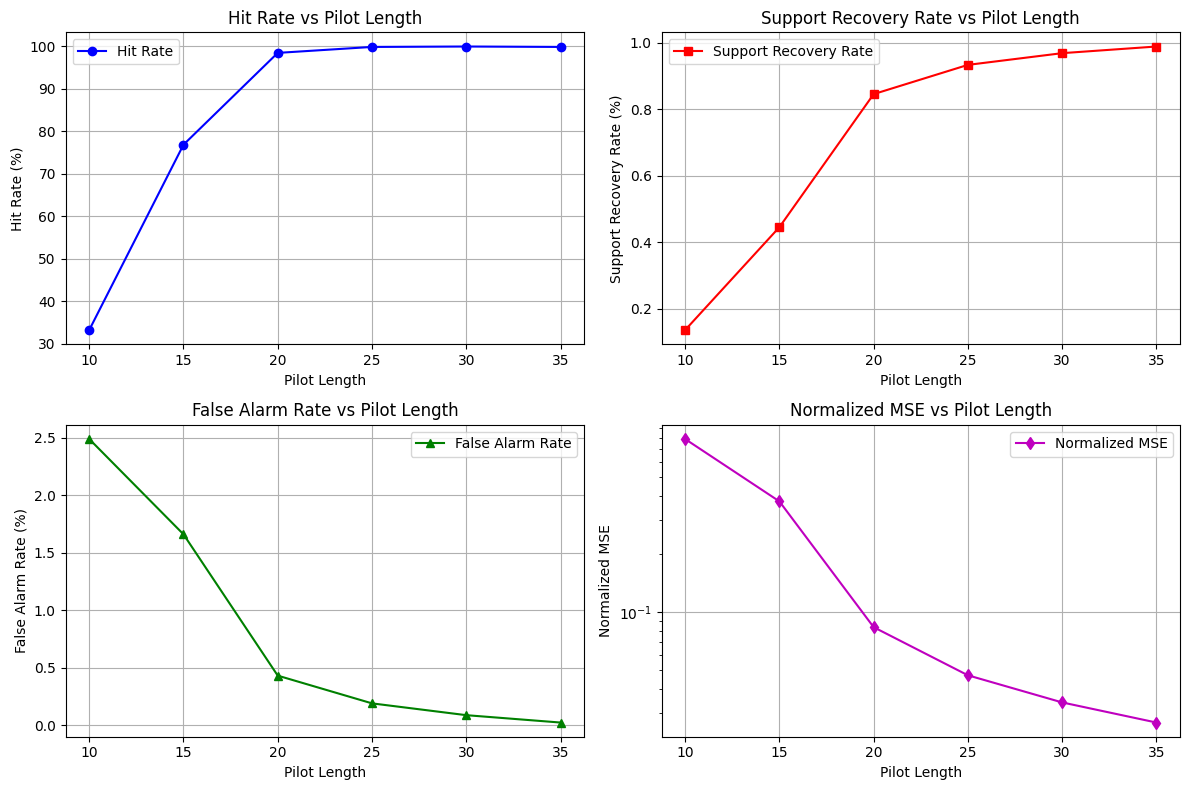

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_sbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sbl_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

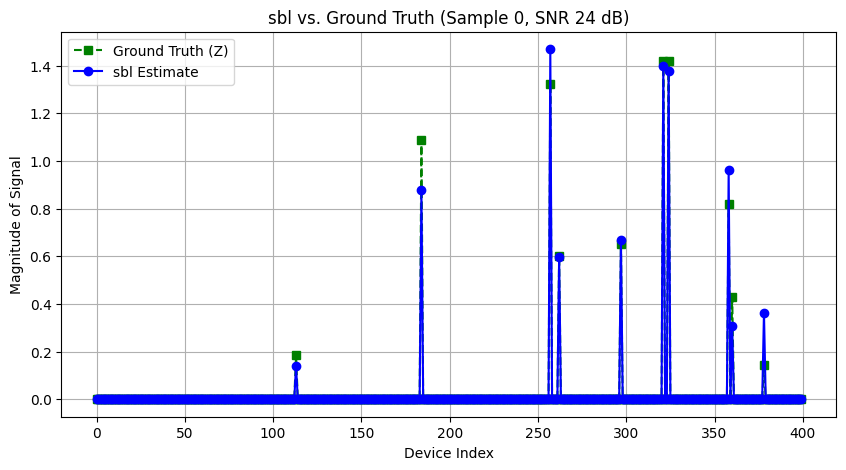

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_sbl_vs_ground_truth(z_sbl, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_sbl_vs_ground_truth(gamma_sbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_sbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


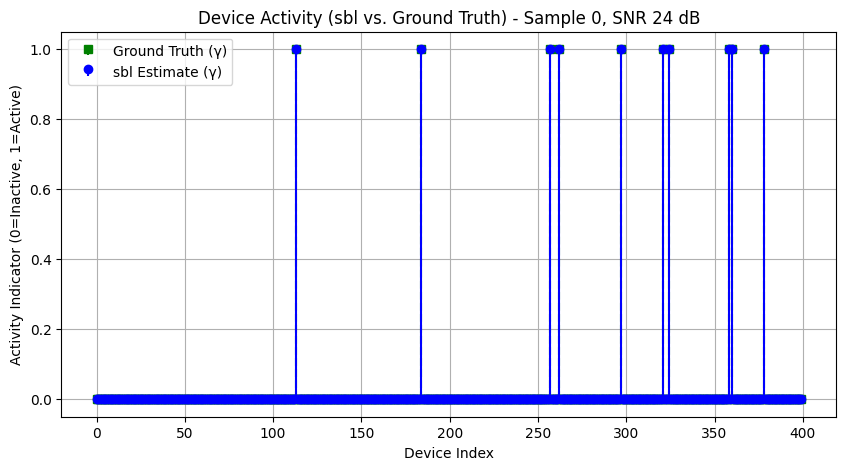

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_sbl_vs_ground_truth(gamma_sbl, all_gamma, sample_index, snr_index, snr_value)